# 3D图像分割
3D图像分割因为几个原因而具有挑战性：在许多显微成像技术中，图像质量在空间上有所变化：例如，当你在样本内部深入成像时，强度和/或对比度会降低。此外，接触的细胞核很难以自动化的方式进行区分。最后但同样重要的是，根据所应用的算法和各自给定的参数，各向异性很难处理。一些算法，如这里演示的[Voronoi-Otsu-Labeling](https://github.com/clEsperanto/pyclesperanto_prototype/blob/master/demo/segmentation/voronoi_otsu_labeling.ipynb)方法，只适用于各向同性数据。

In [1]:
from skimage.io import imread
from pyclesperanto_prototype import imshow
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt

import napari
from napari.utils import nbscreenshot

# For 3D processing, powerful graphics
# processing units might be necessary
cle.select_device('TX')

<NVIDIA GeForce GTX 1650 with Max-Q Design on Platform: NVIDIA CUDA (1 refs)>

为了演示工作流程，我们使用来自[Broad Bio Image Challenge](https://bbbc.broadinstitute.org/BBBC032)的裁剪和重采样的图像数据：
Ljosa V, Sokolnicki KL, Carpenter AE (2012). Annotated high-throughput microscopy image sets for validation. Nature Methods 9(7):637 / doi. PMID: 22743765 PMCID: PMC3627348. 可在 http://dx.doi.org/10.1038/nmeth.2083 获取

In [2]:
input_image = imread("../../data/BMP4blastocystC3-cropped_resampled_8bit.tif")

voxel_size_x = 0.202
voxel_size_y = 0.202
voxel_size_z = 1

为了可视化目的，我们展示沿X、Y和Z方向的强度投影。

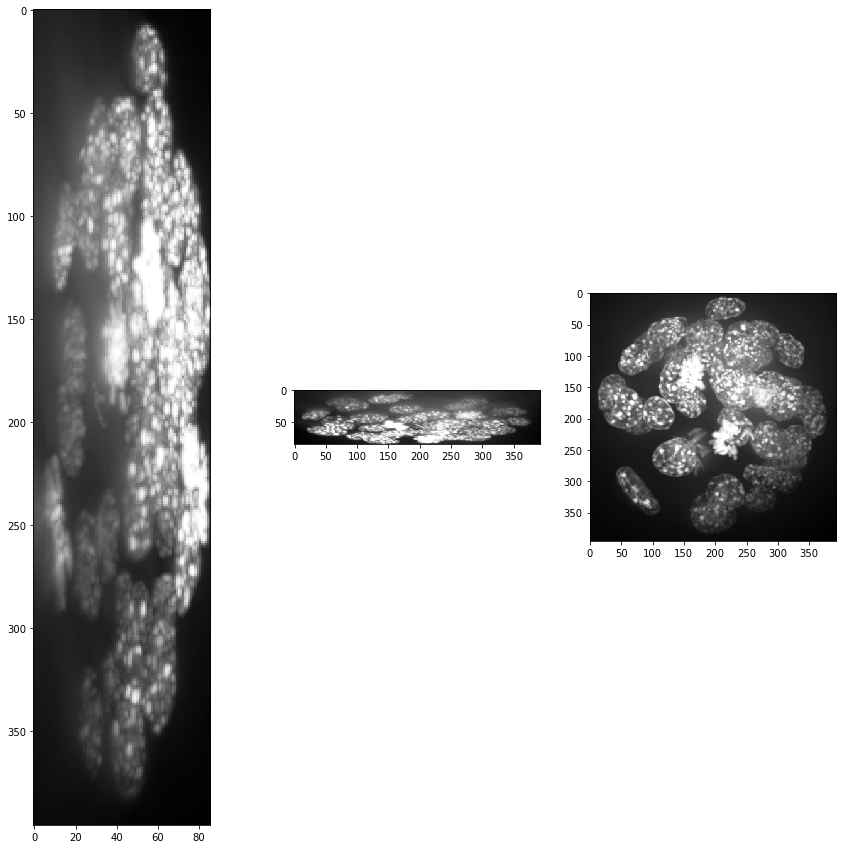

(86, 396, 393)


In [3]:
def show(image_to_show, labels=False):
    """
    这个函数生成三个投影：X、Y和Z方向，并显示它们。
    """
    projection_x = cle.maximum_x_projection(image_to_show)
    projection_y = cle.maximum_y_projection(image_to_show)
    projection_z = cle.maximum_z_projection(image_to_show)

    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    cle.imshow(projection_x, plot=axs[0], labels=labels)
    cle.imshow(projection_y, plot=axs[1], labels=labels)
    cle.imshow(projection_z, plot=axs[2], labels=labels)
    plt.show()

show(input_image)
print(input_image.shape)

显然，体素大小不是各向同性的。因此，我们使用体素大小作为缩放因子来缩放图像，以获得具有各向同性体素的图像堆栈。

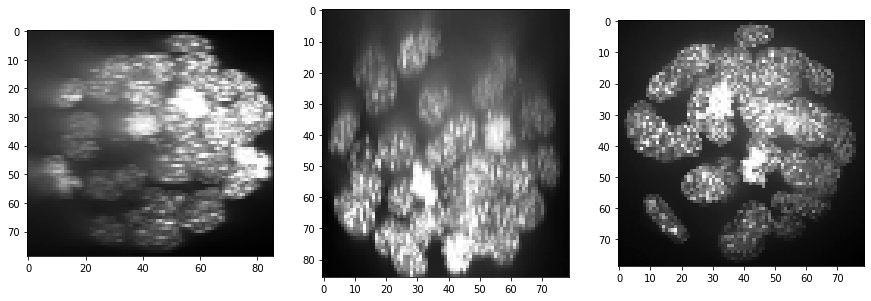

(86, 79, 79)


In [4]:
resampled = cle.scale(input_image, factor_x=voxel_size_x, factor_y=voxel_size_y, factor_z=voxel_size_z, auto_size=True)

show(resampled)
print(resampled.shape)

## 强度和背景校正
正如我们所看到的，强度在Z方向（从切片到切片）减弱，对比度也是如此。至少强度衰减可以被校正。在[CLIJx](https://github.com/clij/clijx)中，这种方法被称为[equalize_mean_intensities_of_slices.](https://clij.github.io/clij2-docs/reference_equalizeMeanIntensitiesOfSlices)

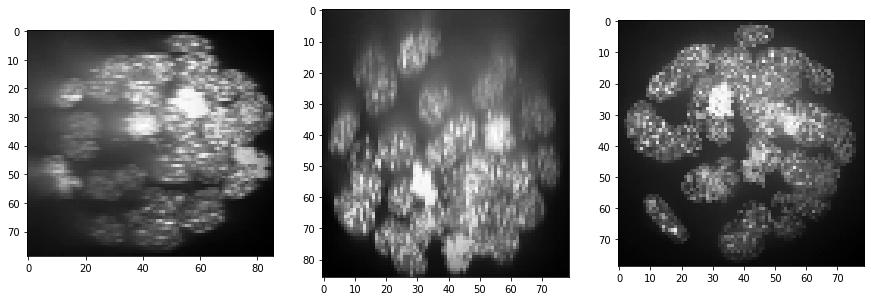

In [5]:
equalized_intensities_stack = cle.create_like(resampled)
a_slice = cle.create([resampled.shape[1], resampled.shape[0]])

num_slices = resampled.shape[0]
mean_intensity_stack = cle.mean_of_all_pixels(resampled)

corrected_slice = None
for z in range(0, num_slices):
    # 从堆栈中获取单个切片
    cle.copy_slice(resampled, a_slice, z)
    # 测量其强度
    mean_intensity_slice = cle.mean_of_all_pixels(a_slice)
    # 校正强度
    correction_factor = mean_intensity_slice/mean_intensity_stack
    corrected_slice = cle.multiply_image_and_scalar(a_slice, corrected_slice, correction_factor)
    # 将切片复制回堆栈中
    cle.copy_slice(corrected_slice, equalized_intensities_stack, z)

show(equalized_intensities_stack)

此外，背景强度似乎在增加，这可能是样本深处散射增加的结果。我们可以通过使用背景减除技术来补偿这一点：

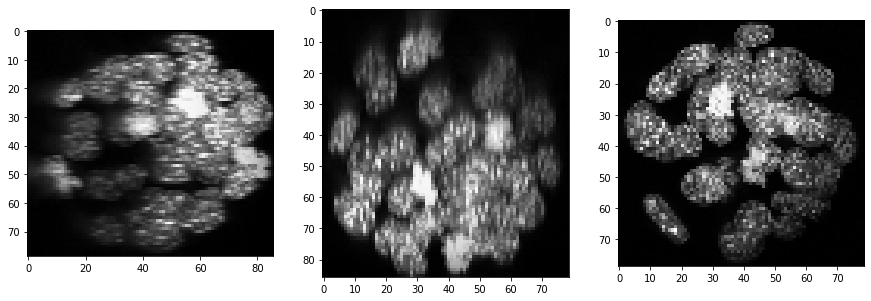

In [6]:
backgrund_subtracted = cle.top_hat_box(equalized_intensities_stack, radius_x=5, radius_y=5, radius_z=5)
show(backgrund_subtracted)

## 分割


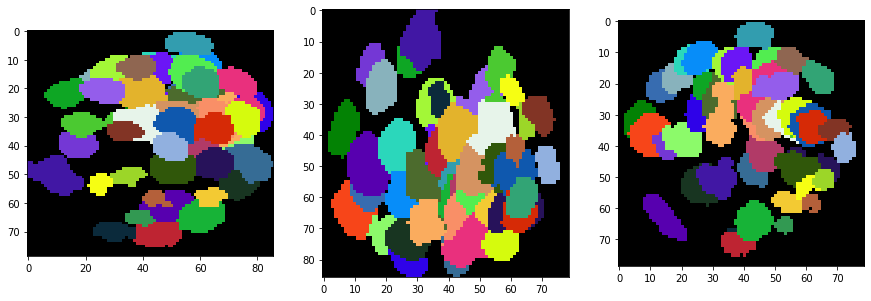

In [7]:
segmented = cle.voronoi_otsu_labeling(backgrund_subtracted, spot_sigma=3, outline_sigma=1)
show(segmented, labels=True)

由于3D分割结果难以检查，我们生成一个包含原始强度 + 分割轮廓的图像堆栈。我们展示这个堆栈的几个切片。

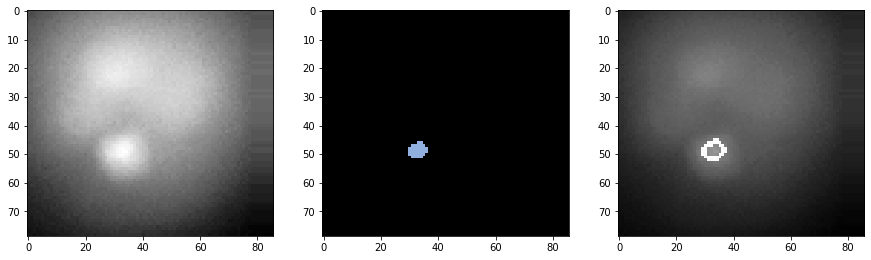

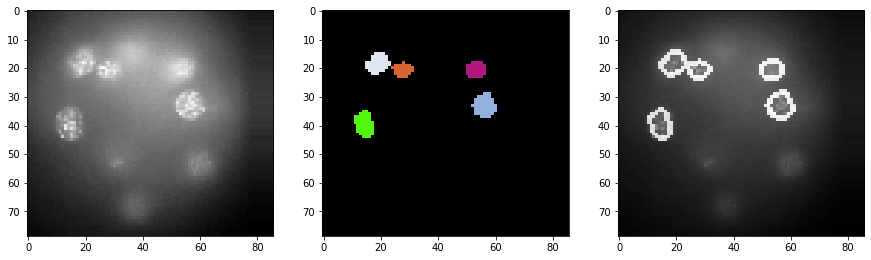

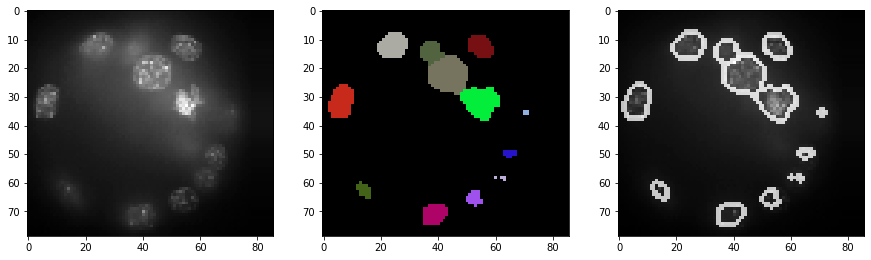

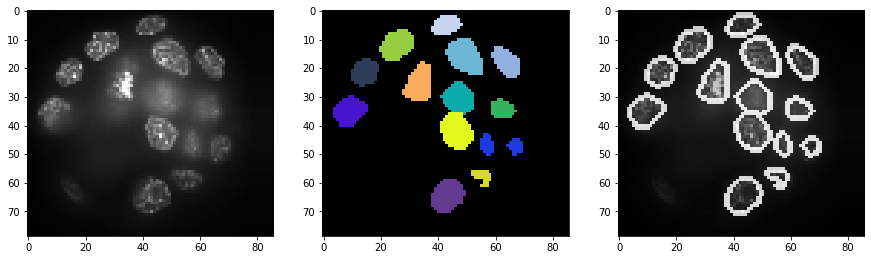

In [8]:
a_slice = cle.create([resampled.shape[1], resampled.shape[0]])
segmented_slice = cle.create([resampled.shape[1], resampled.shape[0]])

for z in range(0, resampled.shape[2], 20):
    label_outlines = None
    combined = None

    # 从强度图像和分割标签图像中获取单个切片
    cle.copy_slice(resampled, a_slice, z)
    cle.copy_slice(segmented, segmented_slice, z)

    # 确定标记对象周围的轮廓
    label_outlines = cle.detect_label_edges(segmented_slice, label_outlines)

    # 合并两个图像
    outline_intensity_factor = cle.maximum_of_all_pixels(a_slice)
    combined = cle.add_images_weighted(a_slice, label_outlines, combined, 1.0, outline_intensity_factor)

    # 可视化
    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    cle.imshow(a_slice, plot=axs[0])
    cle.imshow(segmented_slice, plot=axs[1], labels=True)
    cle.imshow(combined, plot=axs[2])

## 3D可视化
对于实际的3D可视化，你也可以使用[napari](https://napari.org/)。

In [9]:
# 启动napari
viewer = napari.Viewer()

# 显示图像
viewer.add_image(cle.pull(resampled))
viewer.add_image(cle.pull(equalized_intensities_stack))
viewer.add_labels(cle.pull(segmented))

INFO:xmlschema:Resource 'XMLSchema.xsd' is already loaded


<Labels layer 'Labels' at 0x1eba6d51dc0>

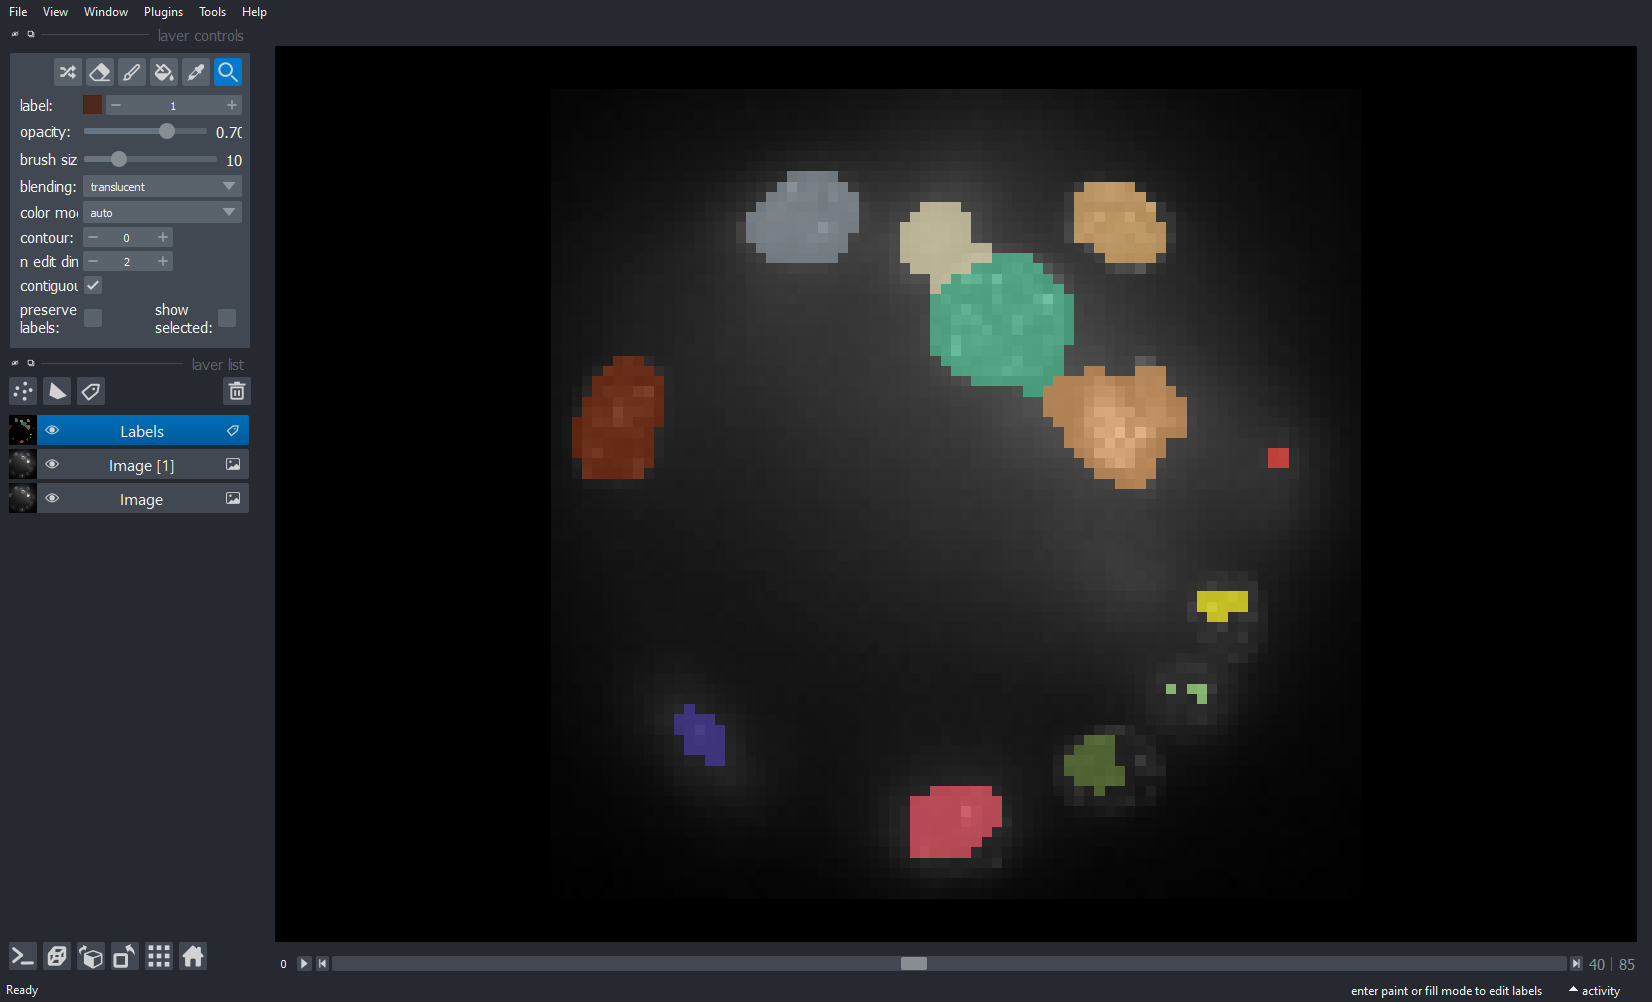

INFO:OpenGL.acceleratesupport:No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


In [10]:
viewer.dims.current_step = (40, 0, 0)
nbscreenshot(viewer)

我们可以通过点击左下角的3D按钮切换到3D视图。

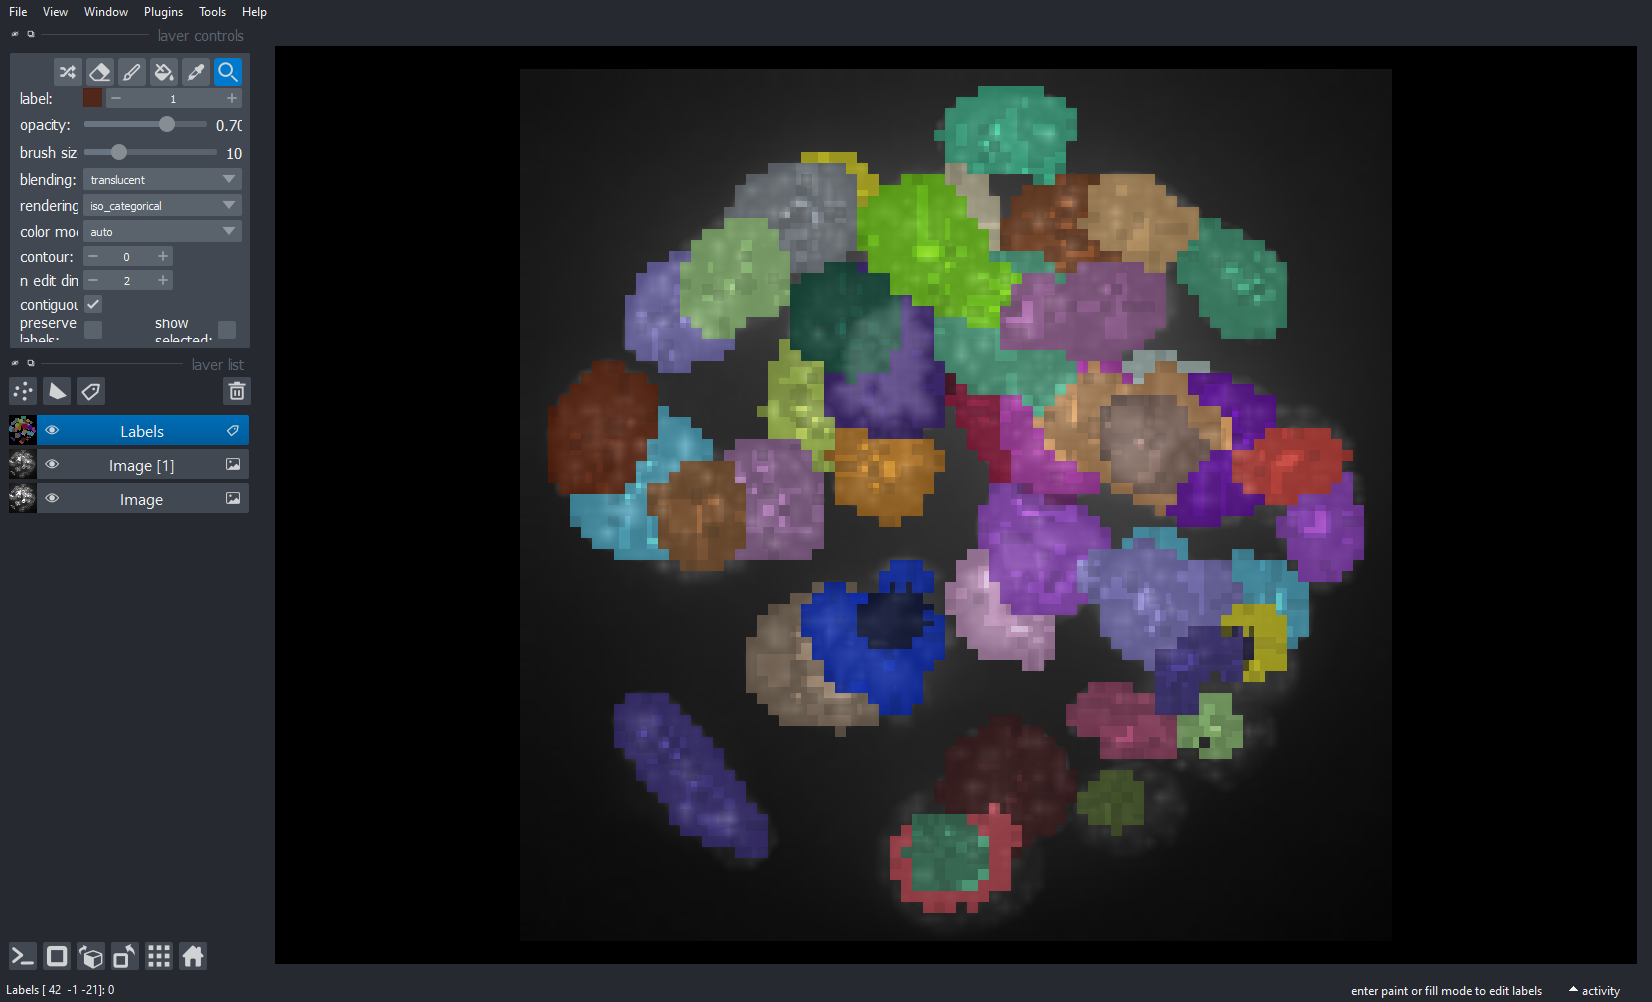

In [11]:
nbscreenshot(viewer)

然后我们还可以调整和倾斜视图。

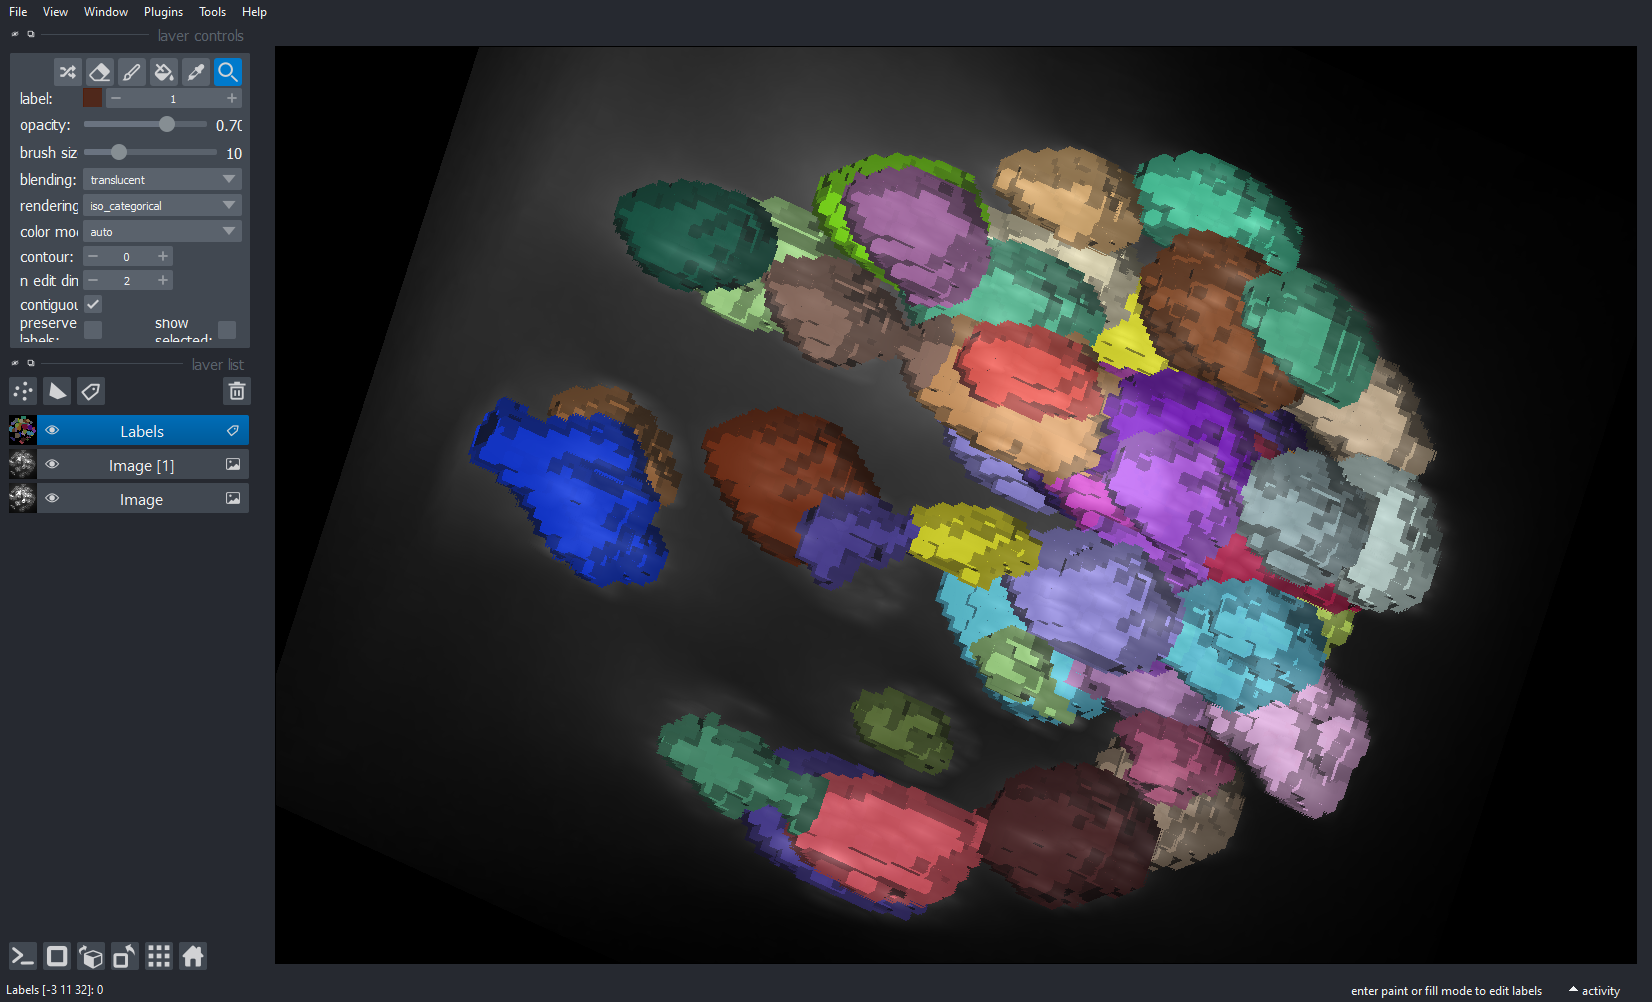

In [12]:
nbscreenshot(viewer)